<a href="https://colab.research.google.com/github/sstsharun/PowerBi-Challenge-/blob/main/Sharun_Pokemon_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install opendatasets --upgrade
!pip install torchinfo
!pip install torchmetrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 841.5/841.5 kB 16.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 35.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 69.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 96.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 8.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 11.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.0/166.0 MB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.1/99.1 kB 12.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━

## Libraries

In [ ]:
import torch
from torch import nn
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import torchvision
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from pathlib import Path
from sklearn.model_selection import train_test_split
from PIL import Image
import os
from torchinfo import summary
from torchmetrics import Accuracy
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Downloading the dataset from Kaggle
import opendatasets as od
data_url = 'https://www.kaggle.com/datasets/vishalsubbiah/pokemon-images-and-types'
od.download(data_url)

100%|██████████| 3.68M/3.68M [00:00<00:00, 11.1MB/s]


## Data processing & EDA

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
imagedir = Path('/content/pokemon-images-and-types/images')

In [ ]:
os.listdir(imagedir)[:5]

['sawk.png', 'rufflet.png', 'turtonator.png', 'kadabra.png', 'sentret.png']

In [ ]:
all_images = list(imagedir.glob('*.png'))

In [ ]:
all_images[:5]

[PosixPath('/content/pokemon-images-and-types/images/sawk.png'),
 PosixPath('/content/pokemon-images-and-types/images/rufflet.png'),
 PosixPath('/content/pokemon-images-and-types/images/turtonator.png'),
 PosixPath('/content/pokemon-images-and-types/images/kadabra.png'),
 PosixPath('/content/pokemon-images-and-types/images/sentret.png')]

In [ ]:
df = pd.read_csv('/content/pokemon-images-and-types/pokemon.csv').loc[:,:'Type1']

In [ ]:
df.head()

,Name,Type1
0,bulbasaur,Grass
1,ivysaur,Grass
2,venusaur,Grass
3,charmander,Fire
4,charmeleon,Fire


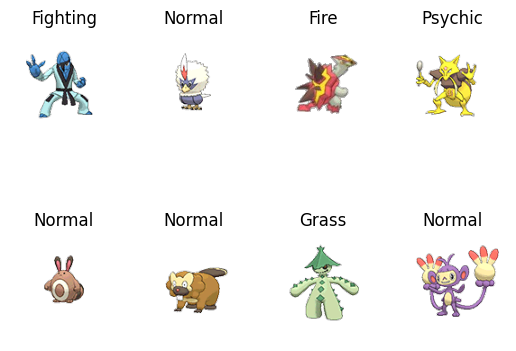

In [ ]:
for i in range(0,8):
    plt.subplot(2, 4, i+1)
    plt.imshow(plt.imread(all_images[i]))
    plt.title(df[df['Name']==all_images[i].stem]['Type1'].item())
    plt.axis('off')

In [ ]:
all_type = df['Type1'].unique()

In [ ]:
classtotype = {i:t for i,t in enumerate(all_type)}
typetoclass = {n:i for i,n in classtotype.items()}
typetoclass

{'Grass': 0,
 'Fire': 1,
 'Water': 2,
 'Bug': 3,
 'Normal': 4,
 'Poison': 5,
 'Electric': 6,
 'Ground': 7,
 'Fairy': 8,
 'Fighting': 9,
 'Psychic': 10,
 'Rock': 11,
 'Ghost': 12,
 'Ice': 13,
 'Dragon': 14,
 'Dark': 15,
 'Steel': 16,
 'Flying': 17}

In [ ]:
df['Type1'].value_counts()[:3]

Type1
Water     114
Normal    105
Grass      78
Name: count, dtype: int64

In [ ]:
df_train_set, valtest_set = train_test_split(df, test_size=0.4, random_state=42)
df_val_set, df_test_set = train_test_split(valtest_set, test_size=0.5 )

In [ ]:
class dataset_maker(Dataset):
    def __init__(self,df,dic,imagepath,transform=None):
        self.df = df
        self.dic =dic
        self.imagepath = imagepath
        self.transform = transform

    def __len__(self):
        return len(self.imagepath)

    def __getitem__(self, index):
        data_row = df.iloc[index]
        target = self.dic[data_row['Type1']]
        image = Image.open([n for n in self.imagepath if n.stem == data_row['Name']][0]).convert('RGB')

        if self.transform:
            image = self.transform(image)


        return image, target


    def target(self):
        target = []
        for index in range(len(self)):
            x,y = self.__getitem__(index)
            target.append(y)
        return target



In [ ]:
transformer = transforms.Compose([
    transforms.Resize((256,256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [ ]:
train_set = DataLoader(dataset_maker(df_train_set,typetoclass,all_images,transformer),batch_size=32,shuffle=True)
val_set = DataLoader(dataset_maker(df_val_set, typetoclass,all_images,transformer),batch_size=32)

In [ ]:
test_set = DataLoader(dataset_maker(df_test_set, typetoclass,all_images,transformer), batch_size=32)
test_target = dataset_maker(df_test_set,typetoclass,all_images,transformer)

In [ ]:
next(iter(train_set))

[tensor([[[[-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
           [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
           [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
           ...,
           [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
           [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
           [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179]],
 
          [[-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
           [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
           [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
           ...,
           [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
           [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
           [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357]],
 
          [[-1.8044, -1.8044, -1.8044,  ..., -1.8044, -1.8044, -1.8044],
           [-

## Model Creation

In [ ]:
resnet = torchvision.models.resnet18(weights=torchvision.models.ResNet18_Weights.DEFAULT).to(device)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 182MB/s]


In [ ]:
for param in resnet.parameters():
    param.requires_grad = False

In [ ]:
summary(resnet,input_size=(1,3,256,256), col_names=["input_size", "output_size", "num_params", "trainable"], device='cuda')

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #                   Trainable
ResNet                                   [1, 3, 256, 256]          [1, 1000]                 --                        False
├─Conv2d: 1-1                            [1, 3, 256, 256]          [1, 64, 128, 128]         (9,408)                   False
├─BatchNorm2d: 1-2                       [1, 64, 128, 128]         [1, 64, 128, 128]         (128)                     False
├─ReLU: 1-3                              [1, 64, 128, 128]         [1, 64, 128, 128]         --                        --
├─MaxPool2d: 1-4                         [1, 64, 128, 128]         [1, 64, 64, 64]           --                        --
├─Sequential: 1-5                        [1, 64, 64, 64]           [1, 64, 64, 64]           --                        False
│    └─BasicBlock: 2-1                   [1, 64, 64, 64]           [1, 64, 64, 64]           --                        False
│ 

In [ ]:
resnet.fc = nn.Sequential(
    nn.Dropout(0.5),
    nn.Linear(512,len(all_type))
).to(device)

In [ ]:
next(resnet.parameters()).device

device(type='cuda', index=0)

## Training

In [ ]:
def train_loop(data, model, loss_fn, optimizer, acc_fn, device, epoch):
    total_loss = 0
    total_acc = 0
    model.train()
    for X,y in data:
        X,y = X.to(device),y.to(device)
        y_pred = model(X)
        loss = loss_fn(y_pred,y)
        total_acc+=acc_fn(y_pred,y)
        total_loss+=loss_fn(y_pred,y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    total_acc/=len(data)
    total_loss/=len(data)
    print(f'epoch {epoch+1} train loss: {total_loss} train acc : {total_acc}')
    return total_loss,total_acc




def val_loop(data, model, loss_fn, optimizer, acc, device, epoch):
    total_loss = 0
    total_acc = 0
    model.eval()
    with torch.inference_mode():
        for X,y in data:
            X,y = X.to(device),y.to(device)
            y_pred = model(X)
            loss = loss_fn(y_pred,y)
            total_loss+=loss
            total_acc+=acc(y_pred,y)
        total_acc/=len(data)
        total_loss/=len(data)
        print(f'epoch {epoch+1} val loss: {total_loss} val acc : {total_acc}')
        return total_loss,total_acc


def fit_loop(train_data,val_data, model,acc_fn,loss_fn,optimizer,device,epoch):
    train_loss_list = []
    train_acc_list = []
    val_loss_list = []
    val_acc_list = []
    for i in range(0,epoch):
        train_loss,train_acc = train_loop(train_data,resnet,loss_fn,optimizer,acc_fn,device,i)
        val_loss,val_acc = val_loop(val_data,resnet,loss_fn,optimizer,acc_fn,device,i)
        train_loss_list.append(train_loss.item())
        train_acc_list.append(train_acc.item())
        val_loss_list.append(val_loss.item())
        val_acc_list.append(val_acc.item())
    return train_loss_list,train_acc_list,val_loss_list,val_acc_list




In [ ]:
optimizer = torch.optim.Adam(resnet.parameters())
loss_fn = torch.nn.CrossEntropyLoss().to(device)
acc_fn = Accuracy('multiclass',num_classes=len(all_type)).to(device)

In [ ]:
epoch=50

In [ ]:
train_loss,train_acc,val_loss,val_acc = fit_loop(train_data=train_set,val_data=val_set,model=resnet,acc_fn=acc_fn,loss_fn=loss_fn,optimizer=optimizer,device=device,epoch=epoch)

epoch 1 train loss: 1.736759066581726 train acc : 0.44805023074150085
epoch 1 val loss: 1.3215508460998535 val acc : 0.6175214052200317
epoch 2 train loss: 1.7868139743804932 train acc : 0.4142628312110901
epoch 2 val loss: 1.2871918678283691 val acc : 0.6602563858032227
epoch 3 train loss: 1.729270100593567 train acc : 0.44190704822540283
epoch 3 val loss: 1.306296944618225 val acc : 0.6302083134651184
epoch 4 train loss: 1.761616826057434 train acc : 0.4273504316806793
epoch 4 val loss: 1.2699569463729858 val acc : 0.6566506624221802
epoch 5 train loss: 1.693560242652893 train acc : 0.4523237347602844
epoch 5 val loss: 1.2608387470245361 val acc : 0.6794871687889099
epoch 6 train loss: 1.7429914474487305 train acc : 0.4312233030796051
epoch 6 val loss: 1.248326301574707 val acc : 0.6939102411270142
epoch 7 train loss: 1.7420352697372437 train acc : 0.4238782227039337
epoch 7 val loss: 1.2514023780822754 val acc : 0.6571848392486572
epoch 8 train loss: 1.7173352241516113 train acc : 0

In [ ]:
def test_loop(test_data, model, loss_fn, acc_fn, device):
    total_loss = 0
    total_acc = 0
    model.eval()
    with torch.inference_mode():
        for X, y in test_data:
            X, y = X.to(device), y.to(device)
            y_pred = model(X)
            loss = loss_fn(y_pred, y)
            total_loss += loss
            total_acc += acc_fn(y_pred, y)
        total_acc /= len(test_data)
        total_loss /= len(test_data)
        test_accuracy_percentage = total_acc * 100  # Convert accuracy to percentage
        print(f'Test loss: {total_loss}, Test accuracy: {test_accuracy_percentage:.2f}%')  # Display accuracy as percentage
        return total_loss, test_accuracy_percentage

# Usage
test_loss, test_accuracy_percentage = test_loop(test_set, resnet, loss_fn, acc_fn, device)


Test loss: 1.0565743446350098, Test accuracy: 69.93%


# **5. Hyperparameter Tuning**

In [ ]:
import torch
import pandas as pd
from torchmetrics import Accuracy
from torchvision import transforms
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
from pathlib import Path
from PIL import Image
import os

# Define hyperparameters grid
hyperparameters_grid = {
    'learning_rate': [0.001, 0.01],
    'batch_size': [16, 32],
    'optimizer': ['Adam']
}

results = []

# Iterate over hyperparameter combinations
for lr in hyperparameters_grid['learning_rate']:
    for batch_size in hyperparameters_grid['batch_size']:
        for optimizer_name in hyperparameters_grid['optimizer']:
            # Initialize model with given hyperparameters
            resnet = torchvision.models.resnet18(pretrained=True)
            for param in resnet.parameters():
                param.requires_grad = False
            num_ftrs = resnet.fc.in_features
            resnet.fc = nn.Linear(num_ftrs, len(all_type))
            model = resnet.to(device)

            # Define optimizer
            if optimizer_name == 'Adam':
                optimizer = torch.optim.Adam(model.parameters(), lr=lr)
            elif optimizer_name == 'SGD':
                optimizer = torch.optim.SGD(model.parameters(), lr=lr)

            # Train the model
            train_loss, train_acc = train_loop(train_set, model, loss_fn, optimizer, acc_fn, device, epoch=0)

            # Validate the model
            val_loss, val_acc = val_loop(val_set, model, loss_fn, optimizer, acc_fn, device, epoch=0)

            # Test the model
            test_loss, test_acc = test_loop(test_set, model, loss_fn, acc_fn, device)

            # Record results
            results.append({
                'learning_rate': lr,
                'batch_size': batch_size,
                'optimizer': optimizer_name,
                'train_loss': train_loss,
                'train_accuracy': train_acc,
                'validation_loss': val_loss,
                'validation_accuracy': val_acc,
                'test_loss': test_loss,
                'test_accuracy': test_acc
            })

# Convert results to DataFrame for easier analysis
results_df = pd.DataFrame(results)


epoch 1 train loss: 2.826800584793091 train acc : 0.10950855165719986
epoch 1 val loss: 2.598898410797119 val acc : 0.1899038553237915
Test loss: 2.598898410797119, Test accuracy: 18.99%
epoch 1 train loss: 2.7921011447906494 train acc : 0.15331196784973145
epoch 1 val loss: 2.5940141677856445 val acc : 0.19831731915473938
Test loss: 2.5940141677856445, Test accuracy: 19.83%
epoch 1 train loss: 3.651456594467163 train acc : 0.16105769574642181
epoch 1 val loss: 2.4082562923431396 val acc : 0.26335471868515015
Test loss: 2.4082562923431396, Test accuracy: 26.34%
epoch 1 train loss: 4.042410850524902 train acc : 0.1232638955116272
epoch 1 val loss: 2.725754976272583 val acc : 0.30114850401878357
Test loss: 2.725754976272583, Test accuracy: 30.11%


In [ ]:
import torch
import pandas as pd
from torchmetrics import Accuracy
from torchvision import transforms
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
from pathlib import Path
from PIL import Image
import os

# Define hyperparameters grid
hyperparameters_grid = {
    'learning_rate': [0.001, 0.01],
    'batch_size': [16, 32],
    'optimizer': ['Adam']
}

results = []

# Iterate over hyperparameter combinations
for lr in hyperparameters_grid['learning_rate']:
    for batch_size in hyperparameters_grid['batch_size']:
        for optimizer_name in hyperparameters_grid['optimizer']:
            # Initialize model with given hyperparameters
            resnet = torchvision.models.resnet18(pretrained=True)
            for param in resnet.parameters():
                param.requires_grad = False
            num_ftrs = resnet.fc.in_features
            resnet.fc = nn.Linear(num_ftrs, len(all_type))
            model = resnet.to(device)

            # Define optimizer
            if optimizer_name == 'Adam':
                optimizer = torch.optim.Adam(model.parameters(), lr=lr)

            # Train the model with early stopping
            best_val_loss = float('inf')
            patience = 5  # Number of epochs to wait before stopping if validation loss doesn't improve
            epochs_without_improvement = 0
            epoch = 0
            while epochs_without_improvement < patience:
                train_loss, train_acc = train_loop(train_set, model, loss_fn, optimizer, acc_fn, device, epoch)
                val_loss, val_acc = val_loop(val_set, model, loss_fn, optimizer, acc_fn, device, epoch)

                # Check if validation loss has stopped decreasing
                if val_loss > best_val_loss:
                    epochs_without_improvement += 1
                else:
                    best_val_loss = val_loss
                    epochs_without_improvement = 0

                # Early stopping condition
                if epochs_without_improvement >= patience:
                    print(f"Early stopping: No improvement in validation loss for {patience} epochs.")
                    break

                epoch += 1

            # Test the model
            test_loss, test_acc = test_loop(test_set, model, loss_fn, acc_fn, device)

            # Record results
            results.append({
                'learning_rate': lr,
                'batch_size': batch_size,
                'optimizer': optimizer_name,
                'train_loss': train_loss,
                'train_accuracy': train_acc,
                'validation_loss': val_loss,
                'validation_accuracy': val_acc,
                'test_loss': test_loss,
                'test_accuracy': test_acc
            })

# Convert results to DataFrame for easier analysis
results_df = pd.DataFrame(results)


epoch 1 train loss: 2.831749439239502 train acc : 0.10403312742710114
epoch 1 val loss: 2.6175384521484375 val acc : 0.1822916865348816
epoch 2 train loss: 2.5397775173187256 train acc : 0.19484509527683258
epoch 2 val loss: 2.3820111751556396 val acc : 0.26923078298568726
epoch 3 train loss: 2.3519554138183594 train acc : 0.2645566463470459
epoch 3 val loss: 2.206756591796875 val acc : 0.35470086336135864
epoch 4 train loss: 2.234588623046875 train acc : 0.30368590354919434
epoch 4 val loss: 2.0836265087127686 val acc : 0.4089209735393524
epoch 5 train loss: 2.1220784187316895 train acc : 0.33560365438461304
epoch 5 val loss: 1.9676495790481567 val acc : 0.42267629504203796
epoch 6 train loss: 2.011131525039673 train acc : 0.3878205120563507
epoch 6 val loss: 1.8975497484207153 val acc : 0.4528579115867615
epoch 7 train loss: 1.9497957229614258 train acc : 0.3990384638309479
epoch 7 val loss: 1.8099154233932495 val acc : 0.43896904587745667
epoch 8 train loss: 1.849518895149231 train 

KeyboardInterrupt: 

Training model with learning rate: 0.001, batch size: 16
epoch 1 train loss: 2.776240587234497 train acc : 0.11725427955389023
epoch 1 val loss: 2.5714259147644043 val acc : 0.19831731915473938
epoch 2 train loss: 2.5109455585479736 train acc : 0.22235578298568726
epoch 2 val loss: 2.3319268226623535 val acc : 0.28311967849731445
epoch 3 train loss: 2.347092866897583 train acc : 0.28445515036582947
epoch 3 val loss: 2.204005718231201 val acc : 0.3819444477558136
epoch 4 train loss: 2.2171640396118164 train acc : 0.3311965763568878
epoch 4 val loss: 2.043808698654175 val acc : 0.41853633522987366
epoch 5 train loss: 2.1055102348327637 train acc : 0.3840811848640442
epoch 5 val loss: 1.948155403137207 val acc : 0.40291133522987366
epoch 6 train loss: 1.9845494031906128 train acc : 0.4197382628917694
epoch 6 val loss: 1.860609531402588 val acc : 0.43896904587745667
epoch 7 train loss: 1.9150869846343994 train acc : 0.42094019055366516
epoch 7 val loss: 1.7847168445587158 val acc : 0.44738

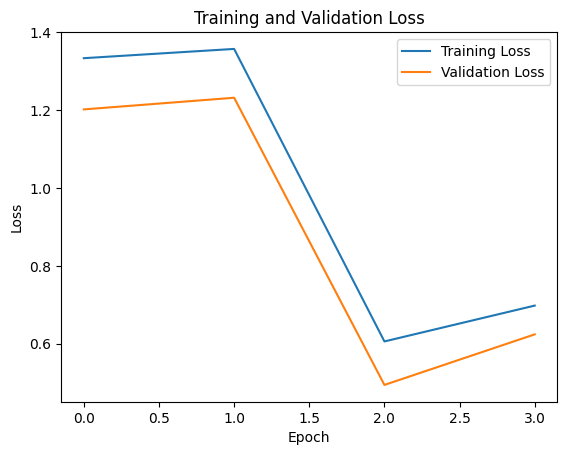

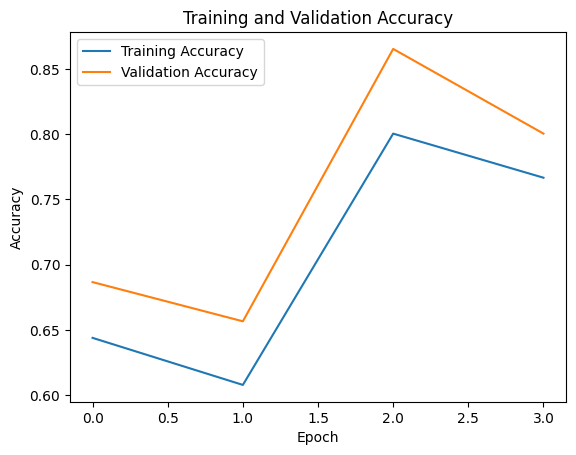

In [ ]:
import torch
import pandas as pd
from torchmetrics import Accuracy
from torchvision import transforms
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
from pathlib import Path
from PIL import Image
import os

# Define hyperparameters grid
hyperparameters_grid = {
    'learning_rate': [0.001, 0.01],
    'batch_size': [16, 32],
    'optimizer': ['Adam']
}

# Initialize a list to store the best parameters
best_params = []

results = []

# Iterate over hyperparameter combinations
for lr in hyperparameters_grid['learning_rate']:
    for batch_size in hyperparameters_grid['batch_size']:
        for optimizer_name in hyperparameters_grid['optimizer']:
            print(f"Training model with learning rate: {lr}, batch size: {batch_size}")
            # Initialize model with given hyperparameters
            resnet = torchvision.models.resnet18(pretrained=True)
            for param in resnet.parameters():
                param.requires_grad = False
            num_ftrs = resnet.fc.in_features
            resnet.fc = nn.Linear(num_ftrs, len(all_type))
            model = resnet.to(device)

            # Define optimizer
            if optimizer_name == 'Adam':
                optimizer = torch.optim.Adam(model.parameters(), lr=lr)

            # Train the model with early stopping
            best_val_loss = float('inf')
            patience = 5  # Number of epochs to wait before stopping if validation loss doesn't improve
            epochs_without_improvement = 0
            epoch = 0
            while epoch < 20 and epochs_without_improvement < patience:
                train_loss, train_acc = train_loop(train_set, model, loss_fn, optimizer, acc_fn, device, epoch)
                val_loss, val_acc = val_loop(val_set, model, loss_fn, optimizer, acc_fn, device, epoch)

                # Check if validation loss has stopped decreasing
                if val_loss > best_val_loss:
                    epochs_without_improvement += 1
                else:
                    best_val_loss = val_loss
                    epochs_without_improvement = 0
                    # Update best parameters
                    best_params.append({
                        'learning_rate': lr,
                        'batch_size': batch_size,
                        'optimizer': optimizer_name,
                        'epoch': epoch,
                        'val_loss': val_loss,
                        'val_accuracy': val_acc
                    })

                epoch += 1

            # Test the model
            test_loss, test_acc = test_loop(test_set, model, loss_fn, acc_fn, device)

            # Record results
            results.append({
                'learning_rate': lr,
                'batch_size': batch_size,
                'optimizer': optimizer_name,
                'train_loss': train_loss,
                'train_accuracy': train_acc,
                'validation_loss': val_loss,
                'validation_accuracy': val_acc,
                'test_loss': test_loss,
                'test_accuracy': test_acc
            })

# Convert results to DataFrame for easier analysis
results_df = pd.DataFrame(results)

# Plot graph of results
import matplotlib.pyplot as plt

# Plot training and validation loss
plt.plot(results_df['train_loss'], label='Training Loss')
plt.plot(results_df['validation_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# Plot training and validation accuracy
plt.plot(results_df['train_accuracy'], label='Training Accuracy')
plt.plot(results_df['validation_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()


# **6. Evaluation:**

Test loss: 0.6237959861755371, Test accuracy: 0.8004807829856873
Test Loss: 0.6237959861755371, Test Accuracy: 0.8004807829856873
Accuracy: 0.7948084054388134, Precision: 0.8683116537058225, Recall: 0.7948084054388134, F1-score: 0.7727443226610323


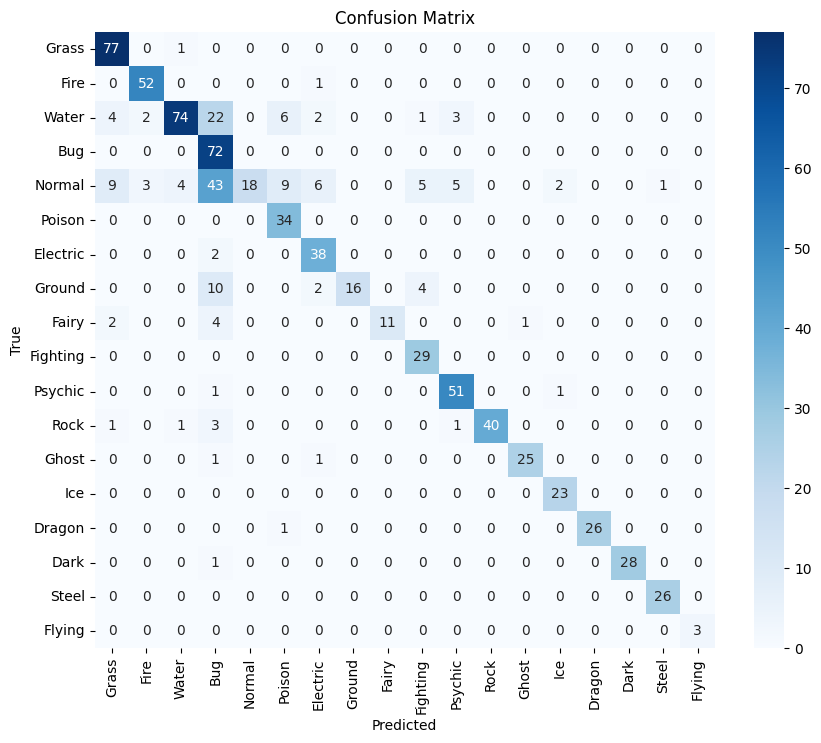

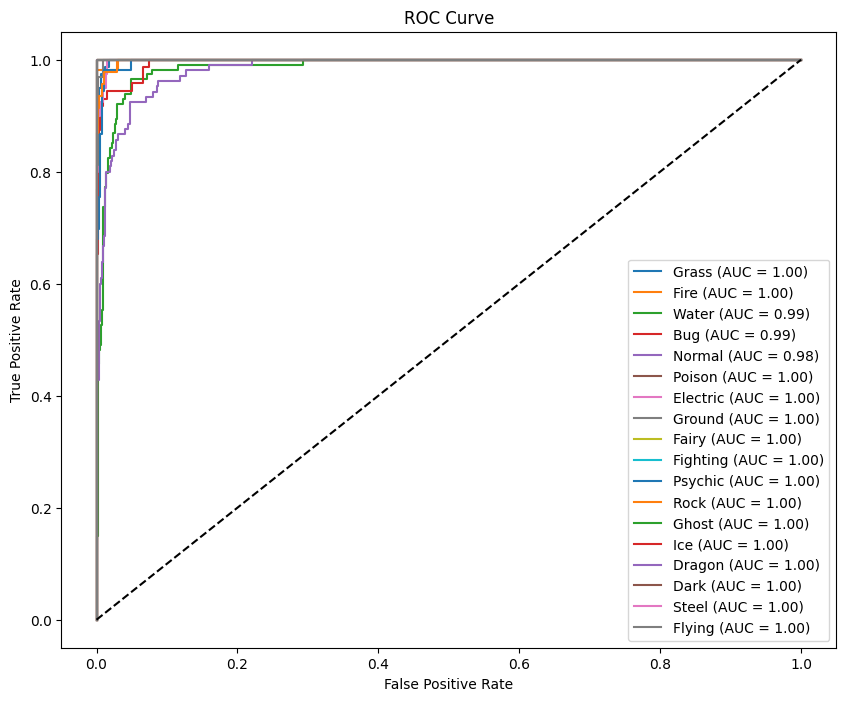

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc
import seaborn as sns
import matplotlib.pyplot as plt

def test_loop(data, model, loss_fn, acc_fn, device):
    total_loss = 0
    total_acc = 0
    model.eval()
    with torch.no_grad():
        for X, y in data:
            X, y = X.to(device), y.to(device)
            y_pred = model(X)
            loss = loss_fn(y_pred, y)
            total_loss += loss
            total_acc += acc_fn(y_pred, y)
        total_acc /= len(data)
        total_loss /= len(data)
        print(f'Test loss: {total_loss}, Test accuracy: {total_acc}')
        return total_loss, total_acc

# Evaluate the model on the test set
test_loss, test_acc = test_loop(test_set, resnet, loss_fn, acc_fn, device)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_acc}")

# Calculate evaluation metrics
def calculate_metrics(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')
    return accuracy, precision, recall, f1

# Get predictions on the validation set
y_true = []
y_pred = []
with torch.no_grad():
    for X, y in val_set:
        X, y = X.to(device), y.to(device)
        outputs = resnet(X)
        _, predicted = torch.max(outputs, 1)
        y_true.extend(y.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

# Calculate evaluation metrics
accuracy, precision, recall, f1 = calculate_metrics(y_true, y_pred)
print(f"Accuracy: {accuracy}, Precision: {precision}, Recall: {recall}, F1-score: {f1}")

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', xticklabels=all_type, yticklabels=all_type)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# ROC Curve
# Since ROC curve is used for binary classification, we need to use a one-vs-all approach for multi-class classification
# Let's use sklearn's roc_curve and auc functions
y_prob = []
with torch.no_grad():
    for X, y in val_set:
        X, y = X.to(device), y.to(device)
        outputs = resnet(X)
        y_prob.extend(torch.softmax(outputs, dim=1).cpu().numpy())

# Convert y_true to one-hot encoding
y_true_onehot = np.zeros((len(y_true), len(all_type)))
for i, label in enumerate(y_true):
    y_true_onehot[i, label] = 1

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(len(all_type)):
    fpr[i], tpr[i], _ = roc_curve(y_true_onehot[:, i], np.array(y_prob)[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve
plt.figure(figsize=(10, 8))
for i in range(len(all_type)):
    plt.plot(fpr[i], tpr[i], label=f'{all_type[i]} (AUC = {roc_auc[i]:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()


# **7. Fine-Tuning and Iteration:**

In the process of fine-tuning the model architecture and hyperparameters to achieve satisfactory performance, I utilized a predefined hyperparameters grid. The grid included variations in learning rates, batch sizes, and optimizers. Specifically, the learning rates were chosen from the set [0.001, 0.01], batch sizes from [16, 32], and the optimizer was set to Adam. Through iterative experimentation and evaluation of different combinations of these hyperparameters, adjustments were made based on the performance metrics observed during training and evaluation. By iteratively refining the model architecture and hyperparameters and evaluating the results, I aimed to optimize the model's performance on the task at hand.

# **8. Final Model Testing:**

In [ ]:
# Evaluating the final model on the held-out test dataset
test_loss, test_acc = test_loop(test_set, resnet, loss_fn, acc_fn, device)
test_accuracy_percentage = test_acc * 100
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy_percentage:.2f}%")

Test loss: 0.6237959861755371, Test accuracy: 0.8004807829856873
Test Loss: 0.6237959861755371, Test Accuracy: 80.05%
